<a href="https://colab.research.google.com/github/DanielPeev1/SentinelFiles/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'notebooks'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12466129244680038633
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12823389963177283956
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import numpy as np
import tensorflow as tf
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, BatchNormalization, Input, concatenate, PReLU, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import Model

dataset = np.load("./dataset.npy", allow_pickle=True)
sar = [ entry["sarImage"] for entry in dataset]

height = [ s.shape[0] for s in sar ]
width = [ s.shape[1] for s in sar ]

maxWidth = max(width)
maxHeight = max(height)

sar = np.array([np.pad(s, [(0, maxHeight - s.shape[0]),(0, maxWidth - s.shape[1]),(0,0)]) for s in sar])
ndvi = np.array([ entry["y"] for entry in dataset])
lastNDVI = np.array([ entry["lastNDVI"] for entry in dataset])
ids = np.array([ entry["id"] for entry in dataset])
lastNDVIDays = np.array([ entry["lastNDVITakenBefore"] for entry in dataset])


lastNDVI = np.reshape(lastNDVI, (lastNDVI.shape[0], lastNDVI.shape[1], lastNDVI.shape[2], 1))

sarShape = sar[0].shape
lastNDVIShape = lastNDVI[0].shape
ndviShape = ndvi[0].shape
ndviReshaped = ndvi.reshape([ndvi.shape[0], ndvi.shape[1] * ndvi.shape[2]])

flatLastNDVI = np.reshape(lastNDVI, [lastNDVI.shape[0], lastNDVIShape[0] * lastNDVIShape[1]])
lastNDVIDays = np.reshape(lastNDVIDays, [lastNDVIDays.shape[0], 1])
flatLastNDVI = np.hstack((flatLastNDVI, lastNDVIDays))

trainID, testID, trainX, testX, trainLastNDVI, testLastNDVI, trainDays, testDays, trainY, testY = train_test_split(ids, sar, lastNDVI, lastNDVIDays, ndviReshaped, test_size=0.20, random_state=48)
print("Sar train: ", trainX.shape)
print("lastNDVI train: ", trainLastNDVI.shape)
print("NDVI train: ", trainY.shape)

print("Sar test: ", testX.shape)
print("lastNDVI test: ", testLastNDVI.shape)
print("NDVI train: ", testY.shape)

Sar train:  (134, 114, 81, 2)
lastNDVI train:  (134, 114, 71, 1)
NDVI train:  (134, 8094)
Sar test:  (34, 114, 81, 2)
lastNDVI test:  (34, 114, 71, 1)
NDVI train:  (34, 8094)


In [ ]:
inputSar = Input(shape=(None, None, 2))
img = BatchNormalization()(inputSar)
img = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same')(img)
img = MaxPool2D(pool_size=(2, 2))(img)
img = Dropout(0.2)(img)
img = Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same')(img)
img = MaxPool2D(pool_size=(2, 2))(img)
img = Dropout(0.2)(img)
img = Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same')(img)
img = MaxPool2D(pool_size=(4, 4))(img)
img = GlobalAveragePooling2D()(img)
img = Model(inputs=inputSar, outputs=img)

print(img.summary())

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, None, None, 2)]   0         
                                                                 
 batch_normalization_8 (Batc  (None, None, None, 2)    8         
 hNormalization)                                                 
                                                                 
 conv2d_39 (Conv2D)          (None, None, None, 64)    1216      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, None, None, 64)   0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, None, None, 64)    0         
                                                                 
 conv2d_40 (Conv2D)          (None, None, None, 128)   738

In [ ]:
#inputLastNDVI = Input(shape=lastNDVIShape[0] * lastNDVIShape[1] + 1)
#lndvi = Dense(8095, activation='relu')(inputLastNDVI)
#lndvi = Model(inputs=inputLastNDVI, outputs=lndvi)
#print(lndvi.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8095)]            0         
                                                                 
 dense_3 (Dense)             (None, 8095)              65537120  
                                                                 
Total params: 65,537,120
Trainable params: 65,537,120
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(lastNDVIShape)
inputLastNDVI = Input(shape=(None, None, 1))
lndvi = Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputLastNDVI)
lndvi = Dropout(0.2)(lndvi)
lndvi = Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu', padding = 'same')(lndvi)
lndvi = MaxPool2D(pool_size=(4, 4))(lndvi)
lndvi = GlobalAveragePooling2D()(lndvi)
lndvi = Model(inputs=inputLastNDVI, outputs=lndvi)
print(lndvi.summary())

(114, 71, 1)
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_42 (Conv2D)          (None, None, None, 256)   2560      
                                                                 
 dropout_26 (Dropout)        (None, None, None, 256)   0         
                                                                 
 conv2d_43 (Conv2D)          (None, None, None, 512)   1180160   
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, None, None, 512)  0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_16  (None, 512)              0         
  (GlobalAveragePooling2D)                   

In [ ]:
daysInput = Input(shape=(1))
days = Dense(10, activation="relu")(daysInput)
days = Model(inputs=daysInput, outputs=days)

In [ ]:
combined = concatenate([img.output, lndvi.output, days.output])
model = Dense(1000, activation="relu")(combined)
model = Dense(ndviReshaped.shape[1])(model)
model = PReLU()(model)
model = Model(inputs=[img.input, lndvi.input, days.input], outputs=model)

print(model.summary())

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, None, None,  0           []                               
                                 2)]                                                              
                                                                                                  
 batch_normalization_8 (BatchNo  (None, None, None,   8          ['input_22[0][0]']               
 rmalization)                   2)                                                                
                                                                                                  
 conv2d_39 (Conv2D)             (None, None, None,   1216        ['batch_normalization_8[0][0]']  
                                64)                                                        

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001, weight_decay=0.01), loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
print(testID)

['s1a-20220723-20220724' 's1b-20210510-20210510' 's1b-20210304-20210303'
 's1a-20220228-20220226' 's1a-20220116-20220115' 's1a-20221101-20221103'
 's1a-20211118-20211118' 's1b-20210827-20210828' 's1a-20210505-20210507'
 's1a-20220524-20220525' 's1a-20220616-20220614' 's1a-20230424-20230422'
 's1b-20210721-20210721' 's1a-20210716-20210716' 's1a-20210704-20210704'
 's1b-20211118-20211118' 's1a-20220621-20220621' 's1a-20230605-20230606'
 's1a-20220722-20220721' 's1b-20210710-20210711' 's1b-20210604-20210606'
 's1a-20220517-20220517' 's1a-20220528-20220527' 's1a-20210209-20210209'
 's1a-20220417-20220415' 's1a-20220325-20220326' 's1b-20210908-20210909'
 's1a-20220803-20220803' 's1a-20220609-20220609' 's1a-20221027-20221027'
 's1b-20210815-20210815' 's1b-20211030-20211029' 's1a-20220704-20220704'
 's1b-20211019-20211019']


In [ ]:
history = model.fit(
    x=[trainX, trainLastNDVI, trainDays],
    y=trainY,
    epochs=30,
    verbose='auto',
    validation_split=0.2)

Epoch 1/30
4/4 [==============================] - 5s 337ms/step - loss: 0.0788 - root_mean_squared_error: 0.2807 - val_loss: 0.1426 - val_root_mean_squared_error: 0.3776
Epoch 2/30
4/4 [==============================] - 1s 237ms/step - loss: 0.0532 - root_mean_squared_error: 0.2307 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2104
Epoch 3/30
4/4 [==============================] - 1s 232ms/step - loss: 0.0396 - root_mean_squared_error: 0.1990 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1804
Epoch 4/30
4/4 [==============================] - 1s 223ms/step - loss: 0.0349 - root_mean_squared_error: 0.1867 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1729
Epoch 5/30
4/4 [==============================] - 1s 222ms/step - loss: 0.0332 - root_mean_squared_error: 0.1823 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1660
Epoch 6/30
4/4 [==============================] - 1s 221ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791 - val_loss: 0.0261 - val_root_mean_sq

In [ ]:
from keras import backend as k

input_images_tensor = tf.cast(tf.constant(trainX), tf.float32)
last_ndvi_tensor = tf.constant(trainLastNDVI)
with tf.GradientTape() as g:
    g.watch(input_images_tensor)
    g.watch(last_ndvi_tensor)
    output_tensor = model([input_images_tensor, last_ndvi_tensor])

gradients = g.gradient(output_tensor, input_images_tensor)
gradients < 0.0001


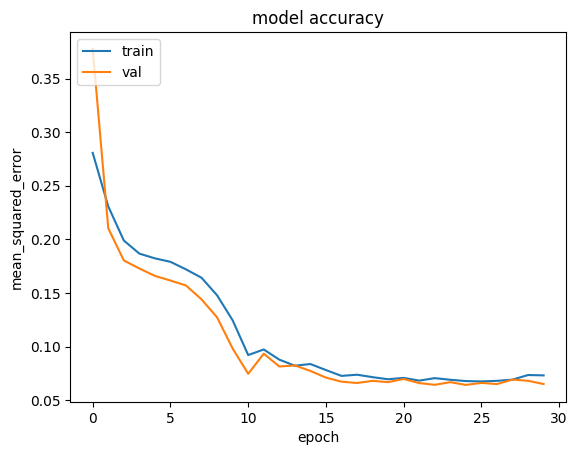

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate([testX, testLastNDVI, testDays], testY)

2/2 [==============================] - 0s 23ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647


[0.004187215585261583, 0.06470870226621628]

In [ ]:
model.save("top_model.keras")

In [1]:
from sklearn.metrics import mean_squared_error
dataset_plus = np.load("./dataset-plus.npy", allow_pickle=True)

entry = dataset[5]


#for idx, entry in enumerate(dataset):
#  if '20230209' in entry['id']:
#    print(idx)
#print(entry['id'])

sar = np.reshape(entry['sarImage'], (1, entry['sarImage'].shape[0], entry['sarImage'].shape[1], entry['sarImage'].shape[2]))
lastNDVI = np.reshape(entry['lastNDVI'], (1, entry['lastNDVI'].shape[0], entry['lastNDVI'].shape[1]))
takenBefore = np.reshape(entry['lastNDVITakenBefore'], (1, 1))

prediction = model.predict([[sar], [lastNDVI], [takenBefore]])

prediction = np.reshape(prediction, ndviShape)
print(prediction.shape)

actual = entry['y']
actual = dataset[151]['y']

plt.matshow(actual, vmin=0, vmax=0.55)
plt.show()
plt.matshow(prediction, vmin=0,vmax=0.55)
plt.show()


mse = mean_squared_error(actual, prediction)
print(np.sqrt(mse))

NameError: ignored

In [ ]:
from keras import backend as K
import psutil


# Check the GPU memory usage
gpu_memory_used = psutil.virtual_memory().used
gpu_memory_total = psutil.virtual_memory().total
gpu_memory_percent = (gpu_memory_used / gpu_memory_total) * 100

print(gpu_memory_percent)

K.clear_session()

32.85708740890424
